## california housing en utilisant les methodes BayesianRidge , LinearRegression, RandomForestRegressor

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics

%matplotlib inline
plt.style.use('ggplot')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#imports from my created functions

In [2]:
def classify_fit_predict(classifier, X_train, Y_train, X_test):
    '''classifier/regression algorithm, fit him to x axis train set and y axis train set and later, predict with x axis test set'''
    
    start_time = datetime.now()
    
    cl = str(classifier)
    tmp = cl.find("(")
    print("Calculating predictions for", cl[:tmp])
    
    clf = classifier
    model = clf.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    
    print(f"{cl[:-2]} is ready... \nCalculation finished in {datetime.now()-start_time}")
    
    return model, y_pred

def automatize_enconding(dataset, column_name, prefix_to_append):
    '''automization of enconding to transform non-logic categorical data into binary one, the returned value will be a dummies dataframe'''
    le = LabelEncoder()
    dummies = pd.get_dummies(dataset[f"{column_name}"], prefix=prefix_to_append)
    return dummies

<p> Goals for this notebook
<dl>
    <dd>> Univariate and multivariate exploratory data analysis</dd>
    <dd>> Fill missing values with supervised learning data imputation </dd>
    <dd>> Identification and cleaning of outliers, using the z-method</dd>
    <dd>> Train the model to predict median_income which is measured in tens of thousands of US Dollars</dd>
</dl>

</p>

In [3]:
df = pd.read_csv("../ressources/housing.csv")
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [4]:
print(f"{df.shape}\n{df.isnull().sum()}")

(20640, 10)
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


#create a table of only null values and remove them in the original dataframe

In [5]:
null_df = df.loc[df.isna().any(axis=1)]
df = df.dropna()
null_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN


<h2>Exploratory data analysis and data pre-processing<h2>

In [6]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


As we can see that are a lot of outliers, let's create a function to remove them, the method used will be the z-score method because it deals greatly with values that goes over 3 stardard deviation out. <br>
We define Z as
$
\begin{align}
Z = \frac{x-\mu}{\sigma}
\end{align}
$
In which $\sigma$ is defined as 
$\sigma = \sqrt{\frac{\sum_{i=1}^{n}(x_i - \overline{x})^2}{n-1}} = \sqrt{\frac{\sum_{i=1}^{n}x_i^2 - n\overline{x}^2}{n-1}}$
</br>
And $\mu$ as
$\overline{x} = \frac{\sum_{i=1}^{n}x_i}{n} = \frac{x_1 + x_2 + ... + x_n}{n} $
<br>
So, this is how we detect outliers. So now for removing them we delimitate values in the range of <br>
$ 
T = \overline{x} \pm 3*\sigma 
$

In [9]:
cols = ['housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value']    

def remove_outliers(columns):
    upper = df[columns].mean() + 3*df[columns].std()
    lower = df[columns].mean() - 3*df[columns].std()
    return df[(df[columns] < upper) & (df[columns] > lower)]

for col in cols:
    df = remove_outliers(col)

### before progressing in the analysis, i'll fill those na's values with machine learning regression and them concatenate it in our dataframe

In [10]:
x_for_test = df.drop(["total_bedrooms", "ocean_proximity"], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x_for_test, df["total_bedrooms"], random_state=334441, test_size=0.25)

classifiers = [
    LinearRegression()
]
models = []

for classifier in classifiers:
    cfp = classify_fit_predict(classifier, x_train, y_train, x_test)
    models.append(cfp)

print(f"{str(models[0][0])[:-2]} got scored at: {(models[0][0].score(x_test, y_test))*100:.2f}% ")

Calculating predictions for LinearRegression
LinearRegression is ready... 
Calculation finished in 0:00:00.036261
LinearRegression got scored at: 95.65% 


In [11]:
pd.set_option('mode.chained_assignment', None)

x_fill = null_df.drop(["total_bedrooms", "ocean_proximity"], axis=1)

model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_fill)

append_pred = pd.DataFrame({"total_bedrooms" : y_pred})

lst = list(range(1,208))

append_pred["index"] = lst
null_df["index"] = lst

null_df = null_df.drop(["total_bedrooms"], axis=1)
null_df = null_df.merge(append_pred, on="index")
null_df = null_df.drop(["index"], axis=1)
null_df

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity,total_bedrooms
0,-122.16,37.77,47.0,1256.0,570.0,218.0,4.3750,161900.0,NEAR BAY,206.793252
1,-122.17,37.75,38.0,992.0,732.0,259.0,1.6196,85100.0,NEAR BAY,282.113801
2,-122.28,37.78,29.0,5154.0,3741.0,1273.0,2.5762,173400.0,NEAR BAY,1272.807861
3,-122.24,37.75,45.0,891.0,384.0,146.0,4.9489,247100.0,NEAR BAY,128.189302
4,-122.10,37.69,41.0,746.0,387.0,161.0,3.9063,178400.0,NEAR BAY,150.842479
...,...,...,...,...,...,...,...,...,...,...
202,-119.19,34.20,18.0,3620.0,3171.0,779.0,3.3409,220500.0,NEAR OCEAN,791.031718
203,-119.18,34.19,19.0,2393.0,1938.0,762.0,1.6953,167400.0,NEAR OCEAN,768.538972
204,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,410700.0,<1H OCEAN,766.646541
205,-118.75,34.29,17.0,5512.0,2734.0,814.0,6.6073,258100.0,<1H OCEAN,876.263500


In [12]:
print(f"{df.shape}, {null_df.shape}")
full_df = pd.concat([df, null_df], ignore_index=True)
df = full_df
df

(18897, 10), (207, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.000000,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.000000,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.000000,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.000000,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.000000,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
19099,-119.19,34.20,18.0,3620.0,791.031718,3171.0,779.0,3.3409,220500.0,NEAR OCEAN
19100,-119.18,34.19,19.0,2393.0,768.538972,1938.0,762.0,1.6953,167400.0,NEAR OCEAN
19101,-118.88,34.17,15.0,4260.0,766.646541,1701.0,669.0,5.1033,410700.0,<1H OCEAN
19102,-118.75,34.29,17.0,5512.0,876.263500,2734.0,814.0,6.6073,258100.0,<1H OCEAN


### let's try to get some new values and them calculate again the correlation so we can try to find some import insight 

In [13]:
df["bedrooms_per_rooms"] = df["total_bedrooms"] / df["total_rooms"]
df["population_per_households"] = df["population"] / df["households"]
df["population_per_bedrooms"] = df["population"] / df["total_bedrooms"]

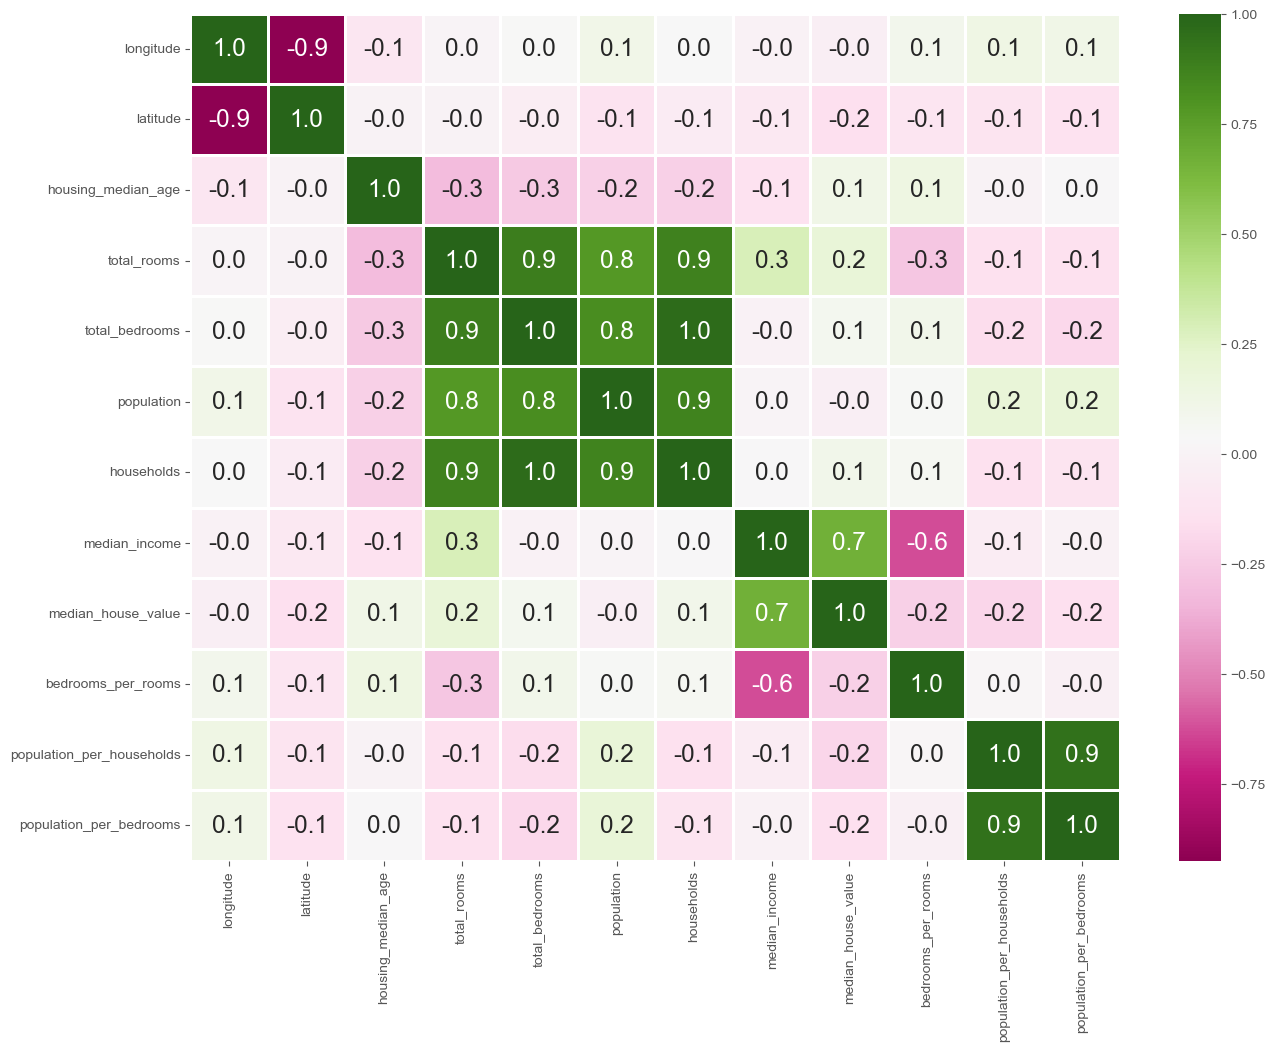

In [14]:
plt.figure(figsize=(15,11))
sns.heatmap(df.corr(), annot=True, fmt=".1f", linewidth=.8, annot_kws={"size": 17.5}, cmap="PiYG")
sns.set(font_scale=1.5)
plt.show()

### let's use enconding to make ocean_proximity into binary data
### i'll use my function created in modules.data_processing

In [15]:
print(automatize_enconding.__doc__)

automatize_enconding(df, "ocean_proximity", "_")

automization of enconding to transform non-logic categorical data into binary one, the returned value will be a dummies dataframe


,__<1H OCEAN,__INLAND,__ISLAND,__NEAR BAY,__NEAR OCEAN
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0
...,...,...,...,...,...
19099,0,0,0,0,1
19100,0,0,0,0,1
19101,1,0,0,0,0
19102,1,0,0,0,0


In [16]:
df = pd.concat([df, automatize_enconding(df, "ocean_proximity", "_")], axis=1)
df = df.drop("ocean_proximity", axis=1)


In [17]:
i_df = df.drop(["longitude", "latitude", "__<1H OCEAN", "__INLAND", "__ISLAND", "__NEAR BAY", "__NEAR OCEAN", "bedrooms_per_rooms", "population_per_households", "population_per_bedrooms"], axis=1)
j_df = df.drop(["housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"], axis=1)

se= StandardScaler()
standardized_df = se.fit_transform(i_df)
print(standardized_df.shape)

standardized_df = pd.DataFrame(standardized_df, columns=i_df.columns)

df = j_df.merge(standardized_df, left_index=True, right_index=True)
df

(19104, 7)


,longitude,latitude,bedrooms_per_rooms,population_per_households,population_per_bedrooms,__<1H OCEAN,__INLAND,__ISLAND,__NEAR BAY,__NEAR OCEAN,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,0.146591,2.555556,2.496124,0,0,0,1,0,0.942049,-1.104659,-1.363447,-1.373354,-1.356427,2.837417,2.259627
1,-122.22,37.86,0.155797,2.109842,2.170886,0,0,0,1,0,-0.672711,3.843374,2.602008,1.732922,3.100436,2.822708,1.412364
2,-122.24,37.85,0.129516,2.802260,2.610526,0,0,0,1,0,1.830168,-0.637624,-1.115860,-1.113377,-1.131822,2.177468,1.354739
3,-122.25,37.85,0.184458,2.547945,2.374468,0,0,0,1,0,1.830168,-0.791181,-0.933214,-1.020741,-0.946854,1.179756,1.257497
4,-122.25,37.85,0.172096,2.181467,2.017857,0,0,0,1,0,1.830168,-0.510323,-0.750567,-1.010282,-0.770693,0.069189,1.265601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,-119.19,34.20,0.218517,4.070603,4.008689,0,0,0,0,1,-0.914925,1.075371,1.323612,2.883395,1.519394,-0.243110,0.169831
19100,-119.18,34.19,0.321161,2.543307,2.521668,0,0,0,0,1,-0.834187,0.099131,1.232319,1.041145,1.444526,-1.260166,-0.308274
19101,-118.88,34.17,0.179964,2.542601,2.218754,1,0,0,0,0,-1.157140,1.584576,1.224638,0.687038,1.034953,0.846135,1.882365
19102,-118.75,34.29,0.158974,3.358722,3.120066,1,0,0,0,0,-0.995663,2.580707,1.669552,2.230464,1.673535,1.775676,0.508376


In [18]:
x_data = df.drop("median_income", axis=1).values
y_data = df["median_income"].values

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=100, test_size=0.25)

classifiers = [
    BayesianRidge(),
    LinearRegression(),
    RandomForestRegressor()
]

models = []

for classifier in classifiers:
    cfp = classify_fit_predict(classifier, x_train, y_train, x_test)
    models.append(cfp)

Calculating predictions for BayesianRidge
BayesianRidge is ready... 
Calculation finished in 0:00:00.007017
Calculating predictions for LinearRegression
LinearRegression is ready... 
Calculation finished in 0:00:00.007020
Calculating predictions for RandomForestRegressor
RandomForestRegressor is ready... 
Calculation finished in 0:00:08.353768


In [19]:
for i in range(len(models)):
    mae = metrics.mean_absolute_error(models[i][1], y_test)
    mse = metrics.mean_squared_error(models[i][1], y_test)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(models[i][1],y_test)

    print(f"{str(models[i][0])[:-2]} got scored at: {(models[i][0].score(x_test, y_test))*100:.2f}% ")
    print("Results of sklearn.metrics:")
    print("MAE:",mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R-Squared:", r2)
    print("\n")

BayesianRidge got scored at: 73.46% 
Results of sklearn.metrics:
MAE: 0.38240644737059215
MSE: 0.2707196523314025
RMSE: 0.5203072672290888
R-Squared: 0.6265099947506956


LinearRegression got scored at: 73.46% 
Results of sklearn.metrics:
MAE: 0.3823284054416695
MSE: 0.27071281870912633
RMSE: 0.5203007002773745
R-Squared: 0.6268836337852091


RandomForestRegressor got scored at: 81.10% 
Results of sklearn.metrics:
MAE: 0.31887443508224517
MSE: 0.1928113345790808
RMSE: 0.4391028747105635
R-Squared: 0.757712431695348




In conclusion, the best regressor was the random forest scoring a Mean square error (MSE) of 0.19, which is pretty good, as well as, getting a really good residual plot, the histogram of the side shows a low variance normal distribuition, which fits great with the analysis. Another good metric was R², a good R² implies that the dependent variable "median_income" is explained by all independent variables in the dataset. 